In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr, kendalltau
import scipy.stats as stats
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr
import cloudpickle as pickle

sns.set_context("paper")
simHei = FontProperties(fname=r'/usr/share/fonts/Chinses/simhei.ttf', size=10) 
import warnings
warnings.filterwarnings('ignore')

# 1. Difference analysis

In [45]:
from scipy.stats import fisher_exact, ranksums
import statsmodels.stats.multitest as multi

life_styles = [('Dietary patterns ', 'metadata_6_food.csv'),
               ('Living environment', 'metadata_5_env.csv'),
               ('maternal pregnancy and childbirth', 'metadata_3_childbirth.csv'),
               ('physical condition', 'metadata_4_illness.csv'),
               ('physical condition of parents', 'metadata_2_parents.csv')]

statistics = []
columns = []
for l, file in life_styles:
    data = pd.read_csv('../data/Preprocess/'+file, index_col=0, sep=',')
    columns.extend(data.columns)
    for v in data.columns:
        values = data.loc[-np.isnan(data[v]), v]
        normal_values = values[[i for i in values.index if i[0]=='N']]
        pp_values = values[[i for i in values.index if i[0]=='P']]
        if len(set(values))>2:
            row.extend([v, normal_values.mean(), pp_values.mean()])
            f, pvalue = ranksums(pp_values, normal_values)
            FC = pp_values.mean()/normal_values.mean()
            statistics.append([l, v, normal_values.mean(), pp_values.mean(), FC, pvalue])
        else:
            a = list(normal_values).count(0)
            b = list(normal_values).count(1)
            c = list(pp_values).count(0)
            d = list(pp_values).count(1)
            oddratio, pvalue = fisher_exact([[a, b], [c, d]], alternative='two-sided')
            statistics.append([l, v, b/float(a+b), d/float(c+d), oddratio, pvalue])

statistics = pd.DataFrame(statistics, index = columns, 
                             columns = ['Life Style', 'Variable','Normal(mean/ratio)', 'PP(mean/ratio)',
                                        'Foldchage/Oddratio','p_value'])
statistics['FDR'] = multi.multipletests(statistics['p_value'], method = 'fdr_bh')[1]
statistics.to_csv('Result/4. LifeStyle_diff.csv')

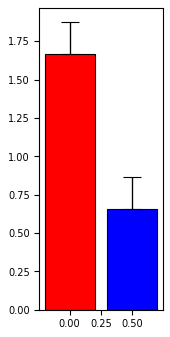

In [114]:
data = pd.read_csv('../data/Preprocess/metadata_6_food.csv', index_col=0, sep=',')

v = 'Seafood'
values = data.loc[-np.isnan(data[v]), v]
normal_values = values[[i for i in values.index if i[0]=='N']]
pp_values = values[[i for i in values.index if i[0]=='P']]

means = [normal_values.mean(), pp_values.mean()]
stds = [normal_values.std(), pp_values.std()]
counts = [len(normal_values), len(pp_values)]
ci95 = 1.96 * np.array(stds) / np.sqrt(np.array(counts)) #95置信区间

_ = plt.figure(figsize=(2, 5), dpi=80)
p = plt.bar(x=[0, 0.5], height=means, yerr=[[0, 0], ci95], width=0.4, align='center', color=['red', 'blue'], edgecolor='black', linewidth=1, ecolor='black', capsize=8)


# 2. Factor network （kendall correlation）

In [57]:
def correlation_analysis(data, by='index', method=spearmanr, sampling=1000):
    if by == 'index':
        data = data.copy().T
    correlation_r_res = []
    correlation_p_res = []
    for i in data.columns:
        row_r = []
        row_p = []
        for j in data.columns:
            temp = data.loc[:, [i, j]]
            temp = temp.dropna(how='any')
            r, p = method(temp[i], temp[j])
            if sampling:
                p = 0
                for rt in range(sampling):
                    x, y = list(temp[i]), list(temp[j])
                    np.random.shuffle(y)
                    r1, _ = method(x, y)
                    if r1 > r:
                        p += 1
                p = min([p/float(sampling), 1-p/float(sampling)])
            row_r.append(r)
            row_p.append(p)
        correlation_r_res.append(row_r)
        correlation_p_res.append(row_p)
    correlation_r_res = pd.DataFrame(correlation_r_res, index=data.columns, columns=data.columns)
    correlation_p_res = pd.DataFrame(correlation_p_res, index=data.columns, columns=data.columns)
    return correlation_r_res, correlation_p_res

In [47]:
data = pd.read_csv('../data/Preprocess/metadata_6_food.csv', index_col=0, sep=',')
data.head()

,Add complementary food age,Like fruit,Like vegetables,Like meat,Like pasta,More bean products,More fried food,More Snacks,More drink,More buying ingredients,...,Fungi,Grease,Drink,Fried food,Sweets,Barbecue,Puffed food,Pickles,MSG,Tonic
PP07_1,6.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP119_1,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP161_1,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0
PP24_1,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP174_1,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0


In [60]:
#corr, corr_p_value = correlation_analysis(data, by='columns', method=kendalltau, sampling=1000)
#corr.to_csv('Result/4.Food_corr.csv')
#corr_p_value.to_csv('Result/4.Food_corr_p.csv')
corr = pd.read_csv('Result/4.Food_corr.csv', index_col=0)
corr_p_value = pd.read_csv('Result/4.Food_corr_p.csv', index_col=0)

In [62]:
loadings = pd.read_csv('../result/Metadata/EFA_food_loading.csv', index_col=0)
corr_links = []
corr_nodes = set()
vs = list(corr.columns)
for i in range(len(corr)-1):
    for j in range(i+1, len(corr)):
        if corr_p_value.iloc[i, j]<0.01 and abs(corr.iloc[i, j])>0.25:
            corr_links.append([vs[i], vs[j], abs(corr.iloc[i, j]), corr.iloc[i, j], np.sign(corr.iloc[i, j])])
        v = vs[i]
        max_factor = loadings.loc[v, loadings.loc[v, :]==loadings.loc[v, :].max()].index[0]
        corr_nodes.add((v, v, 'Food', abs(loadings.loc[v, max_factor]), max_factor))
        v = vs[j]
        max_factor = loadings.loc[v, loadings.loc[v, :]==loadings.loc[v, :].max()].index[0]
        corr_nodes.add((v, v, 'Food', abs(loadings.loc[v, max_factor]), max_factor))
            
corr_links = pd.DataFrame(corr_links, columns=['Source', 'Target', 'Weight', 'r', 'sign_r'])
corr_nodes = pd.DataFrame(corr_nodes, columns=['Id', 'Label', 'node_type', 'node_size', 'factor'])
corr_links.to_csv('Result/4.Food_corr_links.csv', index=False)
corr_nodes.to_csv('Result/4.Food_corr_nodes.csv', index=False)

# 3. correlation (food vs ASV & Metabolism)

In [282]:
food_score = pd.read_csv('Result/sign_recheck/4. Food_EFA_scores_signcheck.csv', index_col=0)
asv_score = pd.read_csv('Result/sign_recheck/2. Microbiome_EFA_scores_signcheck.csv', index_col=0)
meta_score = pd.read_csv('Result/sign_recheck/3. Metabolism_EFA_scores_signcheck.csv', index_col=0)

In [283]:
food_score.shape, asv_score.shape, meta_score.shape

((57, 9), (168, 10), (129, 12))

In [284]:
def correlation_analysis_2_matrix(data1, data2, method=spearmanr, sampling=1000):
    sample_overlap = set(data1.columns)&set(data2.columns)
    temp1 = data1.loc[:, sample_overlap]
    temp2 = data2.loc[:, sample_overlap]
    correlation_r_res = np.zeros((temp1.shape[0], temp2.shape[0]))
    correlation_p_res = np.ones((temp1.shape[0], temp2.shape[0]))
    for i in range(temp1.shape[0]):
        for j in range(temp2.shape[0]):
            r, p = method(temp1.iloc[i, :], temp2.iloc[j, :])
            correlation_r_res[i, j] = r
            correlation_p_res[i, j] = p
            if sampling:
                p = 0
                for rt in range(sampling):
                    x, y = list(temp1.iloc[i, :]), list(temp2.iloc[j, :])
                    np.random.shuffle(y)
                    r1, _ = method(x, y)
                    if r1 > r:
                        p += 1
                p = min([p/float(sampling), 1-p/float(sampling)])
                correlation_p_res[i, j] = p
    correlation_r_res = pd.DataFrame(correlation_r_res, index=temp1.index, columns=temp2.index)
    correlation_p_res = pd.DataFrame(correlation_p_res, index=temp1.index, columns=temp2.index)
    return correlation_r_res, correlation_p_res

In [289]:
corr1, corr_p1 = correlation_analysis_2_matrix(food_score.T, asv_score.T, method=spearmanr, sampling=1000)

In [290]:
corr2, corr_p2 = correlation_analysis_2_matrix(food_score.T, meta_score.T, method=spearmanr, sampling=1000)

In [291]:
corr1.columns = ['ASV_'+i for i in corr1.columns]
corr_p1.columns = ['ASV_'+i for i in corr_p1.columns]
corr2.columns = ['MET_'+i for i in corr2.columns]
corr_p2.columns = ['MET_'+i for i in corr_p2.columns]
corr = pd.concat([corr1, corr2],axis=1)
corr_p = pd.concat([corr_p1, corr_p2],axis=1)

<Figure size 6900x2100 with 0 Axes>

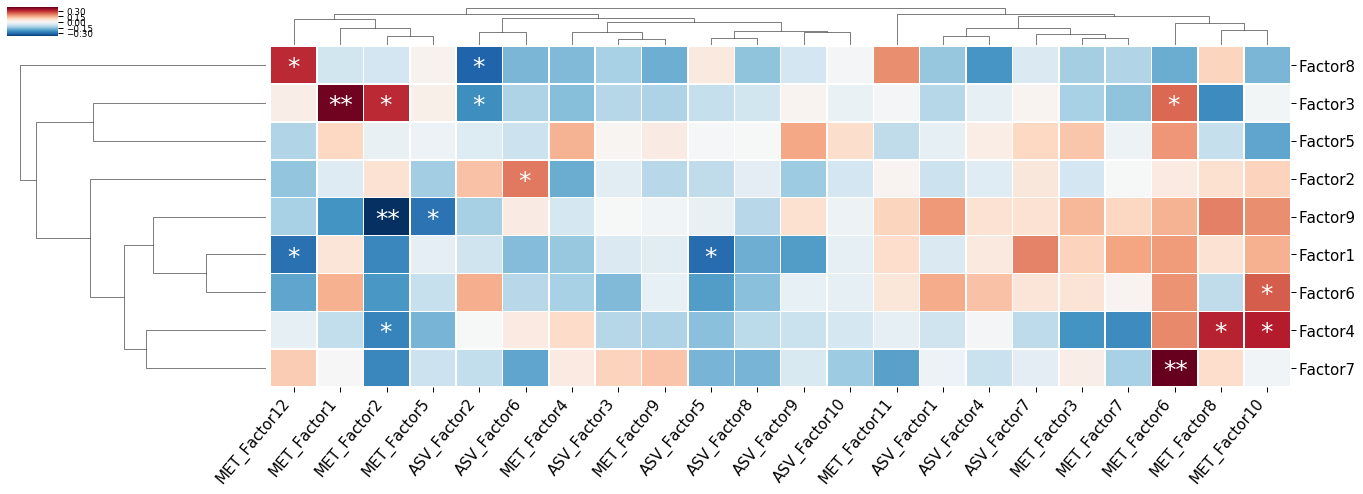

In [311]:
_ = plt.figure(figsize=(23, 7), dpi=300)
g = sns.clustermap(corr, metric='cosine', cmap='RdBu_r', linewidths=0.5, figsize=(23, 7))

_ = g.ax_heatmap.set_ylim(corr.shape[0], -0.0)
xticklabels = np.array(corr.columns)[g.dendrogram_col.reordered_ind]
_ = g.ax_heatmap.set_xticklabels(xticklabels, rotation=50, ha='right', fontsize=15)
yticklabels = np.array(corr.index)[g.dendrogram_row.reordered_ind]
_ = g.ax_heatmap.set_yticklabels(yticklabels, rotation=360, ha='left', fontsize=15)

### -log P-value
for mf in range(len(xticklabels)):
    for af in range(len(yticklabels)):
        log_p = corr_p.loc[yticklabels[af], xticklabels[mf]]
        _ = g.ax_heatmap.annotate('**' if log_p<=0.01 else ('*' if log_p<=0.05 else ''), 
                                  (mf+(0.25 if log_p<=0.01 else 0.35), af+0.75), 
                                 fontsize=25, color='white')

# 4. Loading Bar Plot

In [285]:
from scipy.stats import fisher_exact, ranksums
import statsmodels.stats.multitest as multi
statistics = []
temp_data = food_score.T
for obj in temp_data.index:
    row = []
    normal_abun = temp_data.loc[obj, [i for i in temp_data.columns if i[0]=='N']]
    pp_abun = temp_data.loc[obj, [i for i in temp_data.columns if i[0]=='P']]
    row.extend([obj, normal_abun.mean(), pp_abun.mean()])
    ### Normal vs F_PP
    f, p_value = ranksums(pp_abun, normal_abun)
    FC = pp_abun.mean()-normal_abun.mean()
    row.extend([FC, p_value])
    statistics.append(row)
statistics = pd.DataFrame(statistics, index = temp_data.index, 
                             columns = ['Name','Normal_mean', 'PP_mean', 'FC','p_value'])
statistics['FDR'] = multi.multipletests(statistics['p_value'], method = 'fdr_bh')[1]
statistics.sort_values(['p_value'])

,Name,Normal_mean,PP_mean,FC,p_value,FDR
Factor1,Factor1,0.430990,-0.551667,-0.982656,0.000033,0.00030
Factor6,Factor6,0.159218,-0.203799,-0.363017,0.020571,0.09257
Factor3,Factor3,0.102382,-0.131049,-0.233431,0.394031,0.74773
Factor7,Factor7,0.044385,-0.056813,-0.101198,0.562629,0.74773
Factor8,Factor8,0.113734,-0.145580,-0.259315,0.562629,0.74773
Factor4,Factor4,-0.063018,0.080663,0.143680,0.640951,0.74773
Factor2,Factor2,0.023166,-0.029652,-0.052818,0.675857,0.74773
Factor9,Factor9,0.135176,-0.173026,-0.308202,0.723491,0.74773
Factor5,Factor5,0.032855,-0.042055,-0.074910,0.747730,0.74773


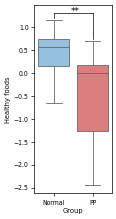

In [286]:
data = food_score

v = 'Factor1'
values = data.loc[-np.isnan(data[v]), v]
normal_values = values[[i for i in values.index if i[0]=='N']]
pp_values = values[[i for i in values.index if i[0]=='P']]

_ = plt.figure(figsize=(2, 5), dpi=50)
plot_data = []
for i in normal_values:
    plot_data.append(['Normal', i])
for i in pp_values:
    plot_data.append(['PP', i])
plot_data = pd.DataFrame(plot_data, columns=['Group', 'Healthy foods'])
sns.boxplot(x="Group", y="Healthy foods", data=plot_data, palette=['#89c3eb', '#ec6d71'])

### 绘制显著性
_ = plt.plot([0, 1], [1.3, 1.3], lw=1., c='k')
_ = plt.plot([0, 0], [1.2, 1.3], lw=1., c='k')
_ = plt.plot([1, 1], [0.75, 1.3], lw=1., c='k')
_ = plt.annotate('**', (0.45, 1.3), fontsize=13)
_ = plt.show()

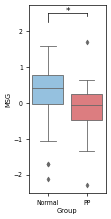

In [287]:
v = 'Factor6'
values = data.loc[-np.isnan(data[v]), v]
normal_values = values[[i for i in values.index if i[0]=='N']]
pp_values = values[[i for i in values.index if i[0]=='P']]

_ = plt.figure(figsize=(2, 5), dpi=50)
plot_data = []
for i in normal_values:
    plot_data.append(['Normal', i])
for i in pp_values:
    plot_data.append(['PP', i])
plot_data = pd.DataFrame(plot_data, columns=['Group', 'MSG'])
sns.boxplot(x="Group", y="MSG", data=plot_data, palette=['#89c3eb', '#ec6d71'])
### 绘制显著性
_ = plt.plot([0, 1], [2.5, 2.5], lw=1., c='k')
_ = plt.plot([0, 0], [2.25, 2.5], lw=1., c='k')
_ = plt.plot([1, 1], [2.42, 2.5], lw=1., c='k')
_ = plt.annotate('*', (0.46, 2.5), fontsize=13)
_ = plt.show()

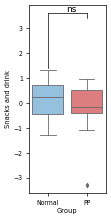

In [288]:
v = 'Factor3'
values = data.loc[-np.isnan(data[v]), v]
normal_values = values[[i for i in values.index if i[0]=='N']]
pp_values = values[[i for i in values.index if i[0]=='P']]

_ = plt.figure(figsize=(2, 5), dpi=50)
plot_data = []
for i in normal_values:
    plot_data.append(['Normal', i])
for i in pp_values:
    plot_data.append(['PP', i])
plot_data = pd.DataFrame(plot_data, columns=['Group', 'Snacks and drink'])
sns.boxplot(x="Group", y="Snacks and drink", data=plot_data, palette=['#89c3eb', '#ec6d71'])
### 绘制显著性
_ = plt.plot([0, 1], [3.6, 3.6], lw=1., c='k')
_ = plt.plot([0, 0], [1.4, 3.6], lw=1., c='k')
_ = plt.plot([1, 1], [3.42, 3.6], lw=1., c='k')
_ = plt.annotate('ns', (0.46, 3.65), fontsize=13)
_ = plt.show()